In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from time import time
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
D:\python\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\python\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\python\envs\deeplearning\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\python\envs\deeplearning\lib\site-packages\tensorflow\python\framewo

In [2]:
df_feature = pd.read_csv("data_preprocessing.csv",skiprows=[1])
X = pd.read_csv("data_preprocessing.csv",skiprows=[1]).values
y = pd.read_csv("label.csv").values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

We have an imbalanced dataset which have 18122 label "=<50k" and 6066 label ">50k"

In [3]:
import collections

collections.Counter(y_train.ravel())

Counter({0: 18122, 1: 6006})

So we use algorithm SMOTE to make our data set balanced.  In short, the idea of the method is to combine under-sampling of the majority class with a special form of over-sampling of the minority class. In the SMOTE algorithm the over-sampling of the minority class is carried out by creating new “synthetic” examples, rather than by over-sampling with replacement from the existing examples. The synthetic observations are generated with the help of the k nearest neighbors (KNN) algorithm. The majority class is under-sampled by randomly removing observations until the minority class becomes some pre-specified percentage of the majority class. 

In [4]:
sm = SMOTE(random_state=42,sampling_strategy = 1.0)
X_res, y_res = sm.fit_resample(X_train, y_train.ravel())

And now we have a balanced datasets.

In [5]:
import collections

collections.Counter(y_res)

Counter({0: 18122, 1: 18122})

In [6]:
def train_predict(learner, ratio, X_train_, y_train_,X_test_,y_test_): 
    results = {}
    start = time() # Get start time
    #Make a sub-testing data from the training data with the percentage 20%
    #Make a sampled validation data from the other training data with the percentage 1% , 10% , 100% 
    #X_train_, X_test_, y_train_, y_test_ = train_test_split( X_train_, y_train_, test_size=0.2, random_state=42, stratify=y_train_)
    if ratio == 1:
        X_val, y_val = X_train_, y_train_
    else:
        X_val, _, y_val, _ = train_test_split(X_train_, y_train_, test_size=(1- ratio), random_state=42, stratify=y_train_)
    # Fit the learner to the validation data 
    learner =  learner.fit(X_val, y_val)
    end = time() # Get end time
    # Calculate the training time
    results['train_time'] = end - start
    start = time() # Get start time
    # Get the predictions on the test set(X_test),
    predictions_test = learner.predict(X_test_)
    # then get predictions on the validation samples(X_train) using .predict() with ratio that we define
    predictions_train = learner.predict(X_val)
    end = time() # Get end time 
    # Calculate the total prediction time
    results['pred_time'] = end - start     
    # Compute accuracy on the validation samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_val, predictions_train)   
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test_, predictions_test)  
    # Compute F-score on the the validation samples using fbeta_score()
    results['f_train'] = fbeta_score(y_val, predictions_train, average = 'binary', beta = 0.5)   
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test_, predictions_test, average = 'binary', beta = 0.5)    
    print("{} trained on {} samples.".format(learner.__class__.__name__, round(ratio*len(X_train_))))  
    return results

we will Initialize the 3 models and store them in 'clf_A', 'clf_B', 'clf_C' with the default settings for each model. We will define 3 ratio of training data to get the sampled validation data.

In [7]:
clf_A = MLPClassifier(random_state = 42)
clf_B = RandomForestClassifier(random_state=42)
clf_C = SVC(random_state = 42)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, ratio_used in enumerate([0.01 , 0.1, 1]):
        results[clf_name][i] = \
        train_predict(clf, ratio_used, X_res, y_res, X_test, y_test)

D:\python\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier trained on 362 samples.


D:\python\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier trained on 3624 samples.


D:\python\envs\deeplearning\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier trained on 36244 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3624 samples.
RandomForestClassifier trained on 36244 samples.
SVC trained on 362 samples.
SVC trained on 3624 samples.
SVC trained on 36244 samples.


This is the result of each model

In [8]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

MLPClassifier


,1%,10%,100%
train_time,1.147080,8.395630,86.673014
pred_time,0.031002,0.044005,0.271020
acc_train,0.933702,0.922185,0.900094
acc_test,0.779214,0.800265,0.807061
f_train,0.925727,0.911314,0.883212
f_test,0.572394,0.604814,0.614781


RandomForestClassifier


,1%,10%,100%
train_time,0.472037,0.692053,7.034528
pred_time,0.157011,0.185013,1.122085
acc_train,0.997238,0.992274,0.976493
acc_test,0.801757,0.817669,0.828609
f_train,0.995600,0.989378,0.973813
f_test,0.606110,0.632196,0.655308


SVC


,1%,10%,100%
train_time,0.039007,0.713055,100.014506
pred_time,0.539033,1.286095,56.150214
acc_train,0.848066,0.855684,0.857604
acc_test,0.757998,0.783524,0.807227
f_train,0.821186,0.835685,0.837827
f_test,0.550063,0.583380,0.615906


D:\python\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
D:\python\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


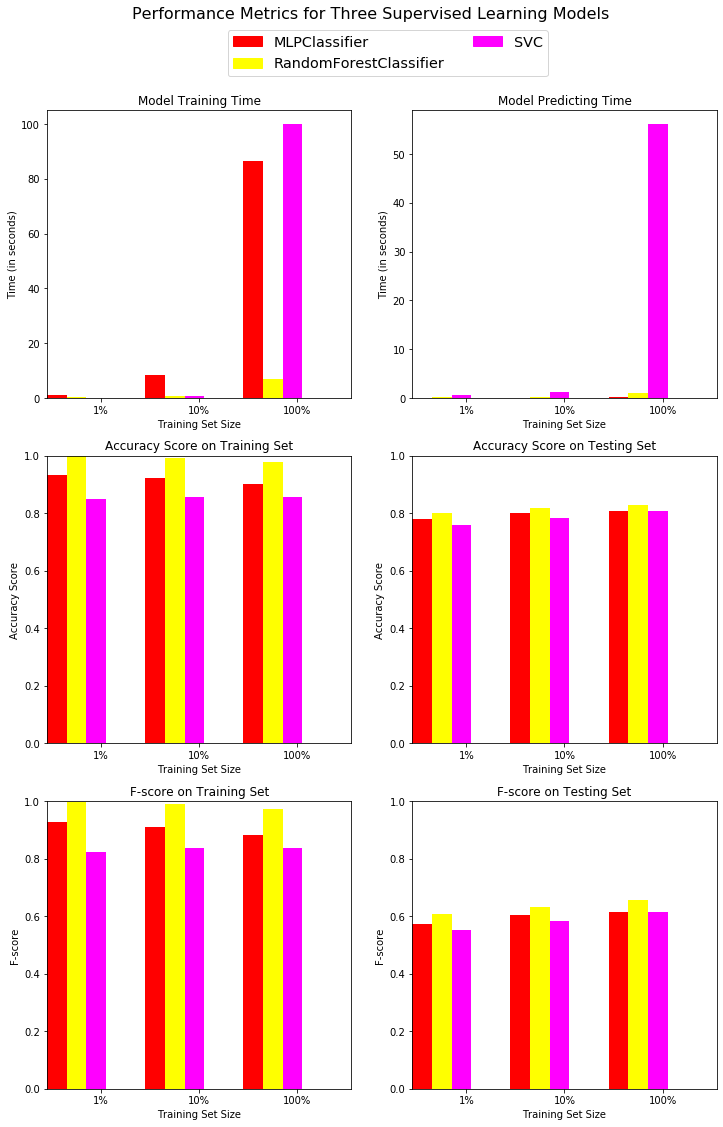

In [9]:
fig, ax = plt.subplots(3, 2, figsize = (12,18))

# Constants
bar_width = 0.2
colors =  ['#ff0000', '#ffff00', '#ff00ff']

# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time','pred_time', 'acc_train', 'acc_test', 'f_train', 'f_test']):
        for i in np.arange(3):
                
            # Creative plot code
            ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
            ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
            ax[j//2, j%2].set_xlabel("Training Set Size")
            ax[j//2, j%2].set_xlim((-0.1, 3.0))
    
# Add y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Time (in seconds)" )
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 1].set_ylabel("Accuracy Score")
ax[2, 0].set_ylabel("F-score")
ax[2, 1].set_ylabel("F-score")
    
# Add titles
ax[0, 0].set_title("Model Training Time")
ax[0, 1].set_title("Model Predicting Time")
ax[1, 0].set_title("Accuracy Score on Training Set")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[2, 0].set_title("F-score on Training Set")
ax[2, 1].set_title("F-score on Testing Set")
    
# Set y-limits for score panels
ax[1, 0].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[2, 0].set_ylim((0, 1))
ax[2, 1].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
plt.legend(handles = patches, bbox_to_anchor = (-0.08, 3.68), \
            loc = 'upper center', borderaxespad = 0., ncol = 2, fontsize = 'x-large')
    
# Aesthetics
plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 0.96)

fig.tight_layout()
fig.show()

According to the model performance graph above, we see that random forest and neural network are overfitting in the training set with the accuracy and the f-score high. We can see the big different between the result in the training set and test set. But with the support vector machine, the different is not too much and its result is the best in accuracy and f-score. We can say that the support vector machine does not overfit too much on the training set. So we choose Support vector machine to continue.

But according to the model performance graph above, Support Vector Classfier which takes dramatically more time to train and predict, but its results is reasonable by comparing the result between training set and test set. So we can choose other algorithm to discover like Adaboosting

In [10]:
from sklearn.ensemble import AdaBoostClassifier

clf_A = AdaBoostClassifier(random_state = 42)
clf_B = SVC(random_state = 42)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, ratio_used in enumerate([0.01 , 0.1, 1]):
        results[clf_name][i] = \
        train_predict(clf, ratio_used, X_res, y_res, X_test, y_test)

AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3624 samples.
AdaBoostClassifier trained on 36244 samples.
SVC trained on 362 samples.
SVC trained on 3624 samples.
SVC trained on 36244 samples.


D:\python\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
D:\python\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


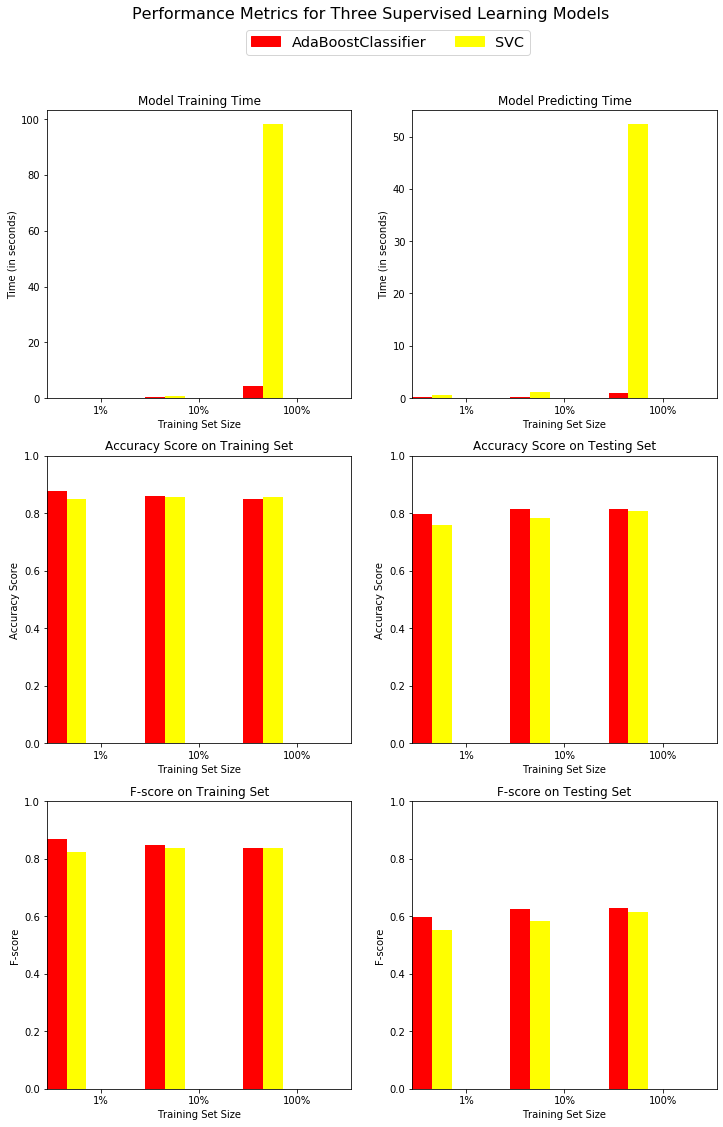

In [11]:
fig, ax = plt.subplots(3, 2, figsize = (12,18))

# Constants
bar_width = 0.2
colors =  ['#ff0000', '#ffff00']
# Super loop to plot four panels of data
for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['train_time','pred_time', 'acc_train', 'acc_test', 'f_train', 'f_test']):
        for i in np.arange(3):
                
            # Creative plot code
            ax[j//2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j//2, j%2].set_xticks([0.45, 1.45, 2.45])
            ax[j//2, j%2].set_xticklabels(["1%", "10%", "100%"])
            ax[j//2, j%2].set_xlabel("Training Set Size")
            ax[j//2, j%2].set_xlim((-0.1, 3.0))
    
# Add y-labels
ax[0, 0].set_ylabel("Time (in seconds)")
ax[0, 1].set_ylabel("Time (in seconds)" )
ax[1, 0].set_ylabel("Accuracy Score")
ax[1, 1].set_ylabel("Accuracy Score")
ax[2, 0].set_ylabel("F-score")
ax[2, 1].set_ylabel("F-score")
    
# Add titles
ax[0, 0].set_title("Model Training Time")
ax[0, 1].set_title("Model Predicting Time")
ax[1, 0].set_title("Accuracy Score on Training Set")
ax[1, 1].set_title("Accuracy Score on Testing Set")
ax[2, 0].set_title("F-score on Training Set")
ax[2, 1].set_title("F-score on Testing Set")
    
# Set y-limits for score panels
ax[1, 0].set_ylim((0, 1))
ax[1, 1].set_ylim((0, 1))
ax[2, 0].set_ylim((0, 1))
ax[2, 1].set_ylim((0, 1))

# Create patches for the legend
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
plt.legend(handles = patches, bbox_to_anchor = (-0.08, 3.68), \
            loc = 'upper center', borderaxespad = 0., ncol = 2, fontsize = 'x-large')
    
# Aesthetics
plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 0.96)

fig.tight_layout()
fig.show()

In [12]:
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

AdaBoostClassifier


,1%,10%,100%
train_time,0.176012,0.324024,4.334326
pred_time,0.134009,0.189016,0.945073
acc_train,0.878453,0.858168,0.849520
acc_test,0.796287,0.813360,0.814354
f_train,0.867725,0.848309,0.837016
f_test,0.597629,0.625131,0.626679


SVC


,1%,10%,100%
train_time,0.047015,0.734038,98.235373
pred_time,0.510025,1.215091,52.400933
acc_train,0.848066,0.855684,0.857604
acc_test,0.757998,0.783524,0.807227
f_train,0.821186,0.835685,0.837827
f_test,0.550063,0.583380,0.615906
